In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.


In [13]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet


In [3]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [0]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

In [0]:
DATASET_DIR = 'dataset'
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [0]:
os.makedirs(DATASET_DIR, exist_ok=True)

In [7]:
!ls

9ca34fad64ded1bf.jpg  dataset	       LICENSE		 setup.py
annotations.csv       examples	       myzipfile.zip	 snapshots
build		      images	       README.md	 tests
classes.csv	      images.jpg       requirements.txt
CONTRIBUTORS.md       keras_retinanet  setup.cfg


In [8]:
with zipfile.ZipFile('/content/keras-retinanet/myzipfile.zip', 'r') as zip_ref:
  zip_ref.extractall(DATASET_DIR)
print('Extract completed!')

Extract completed!


In [0]:
annotations = []
classes = set([])

for xml_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".xml")]:
  tree = ET.parse(os.path.join(DATASET_DIR, xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join(DATASET_DIR, elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          for subsubelem in subelem:
            coords.append(subsubelem.text)
      item = [file_name] + coords + [obj_name]
      annotations.append(item)
      classes.add(obj_name)

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

In [10]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [0]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 16 --steps 100 --epochs 10 csv annotations.csv classes.csv

In [34]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

import keras

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pandas

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

tf.compat.v1.ConfigProto()

In [35]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5
tracking <tf.Variable 'Variable_20:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_21:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_22:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_23:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_24:0' shape=(9, 4) dtype=float32> anchors


In [0]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [0]:
THRES_SCORE = 0.7

Saving 08dccefc47c0b41d.jpg to 08dccefc47c0b41d (3).jpg
Running inference on: 08dccefc47c0b41d.jpg
processing time:  0.3474111557006836


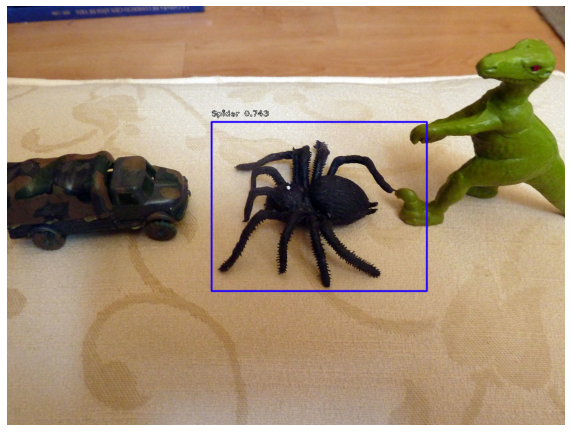

In [42]:
uploaded = files.upload()
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time

processing time:  0.34476590156555176


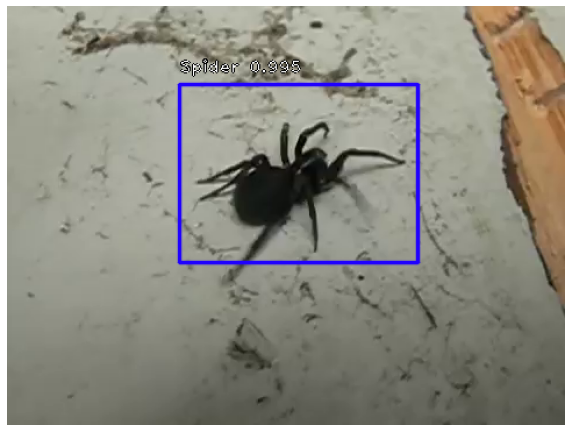

processing time:  0.28470659255981445


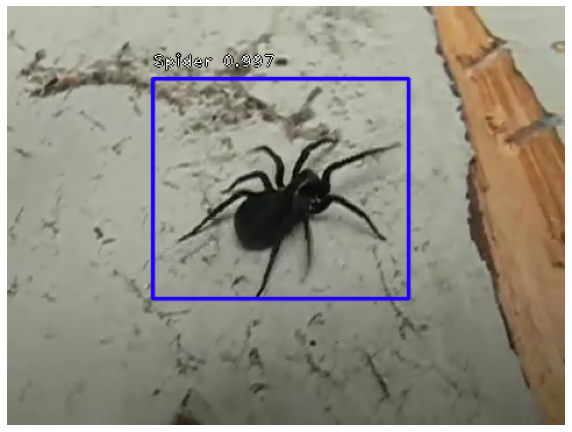

processing time:  0.2549588680267334


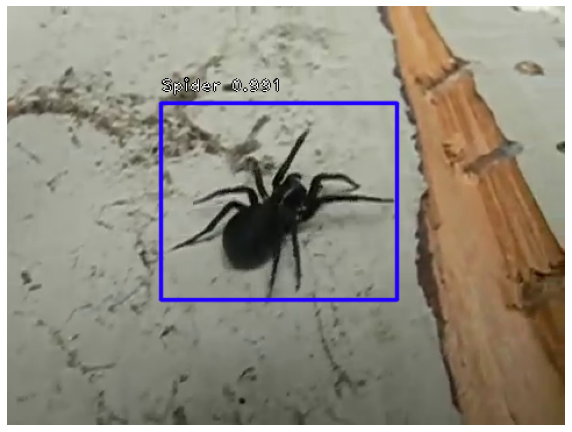

processing time:  0.26273131370544434


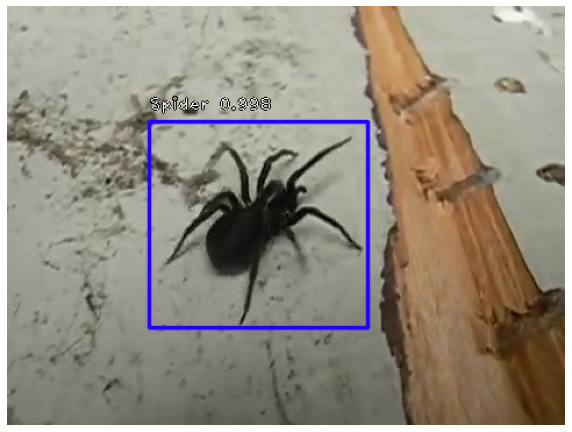

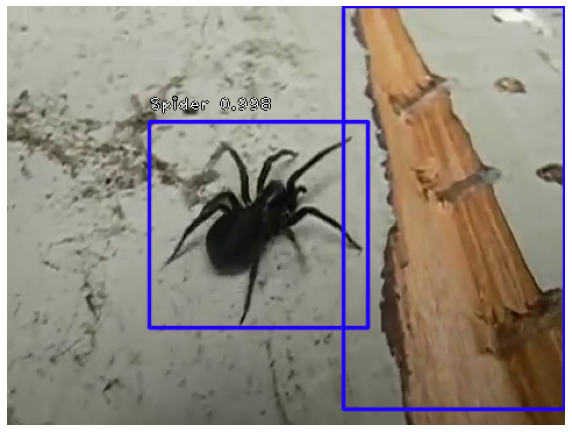

processing time:  0.2572672367095947


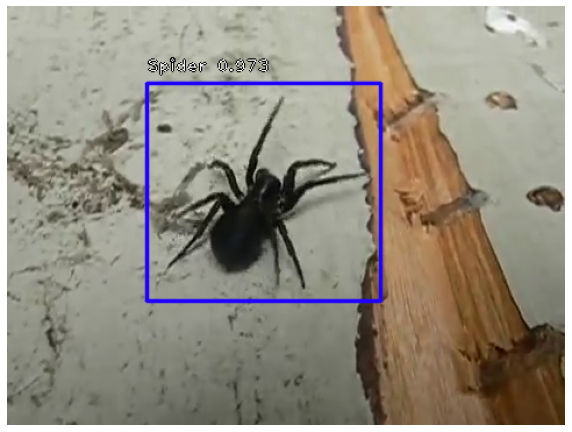

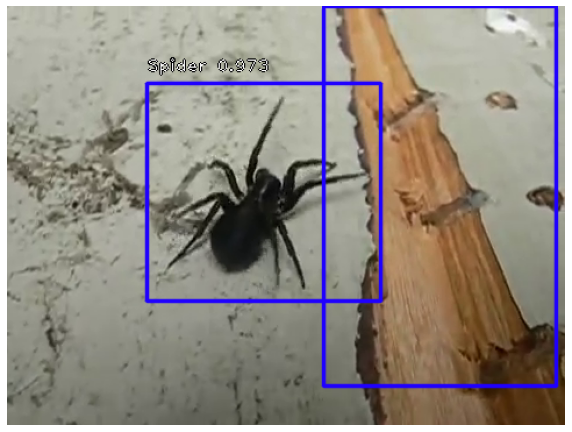

processing time:  0.2609899044036865


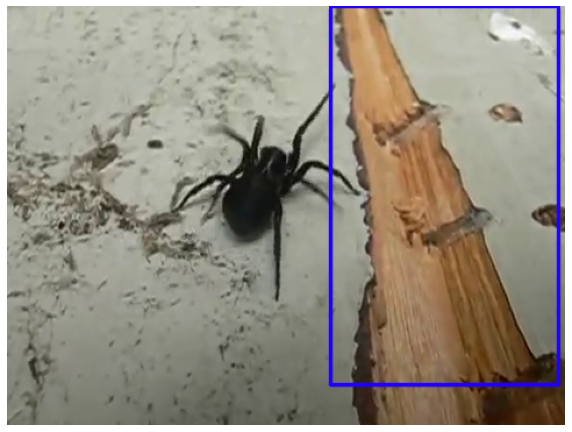

processing time:  0.257357120513916


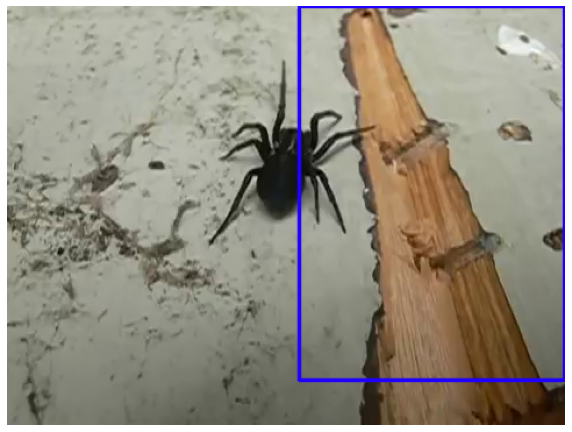

processing time:  0.2598445415496826


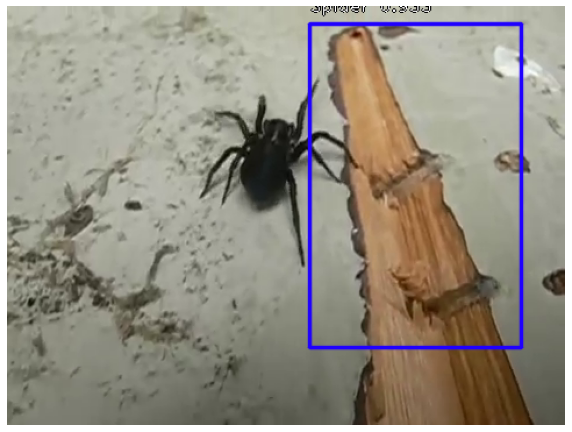

processing time:  0.25747227668762207


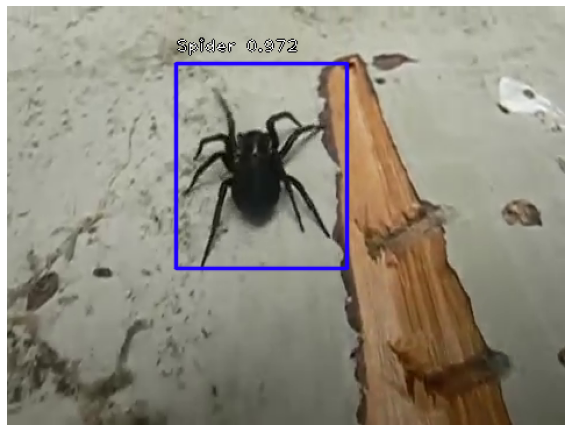

processing time:  0.25688648223876953


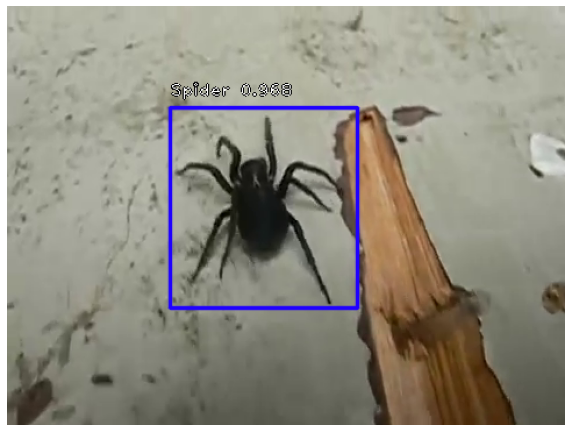

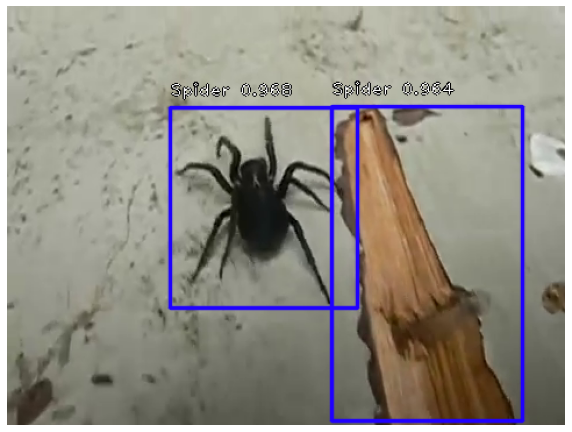

processing time:  0.254425048828125


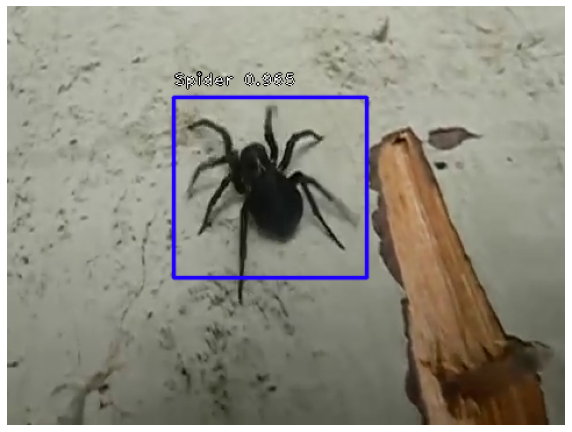

processing time:  0.2511756420135498


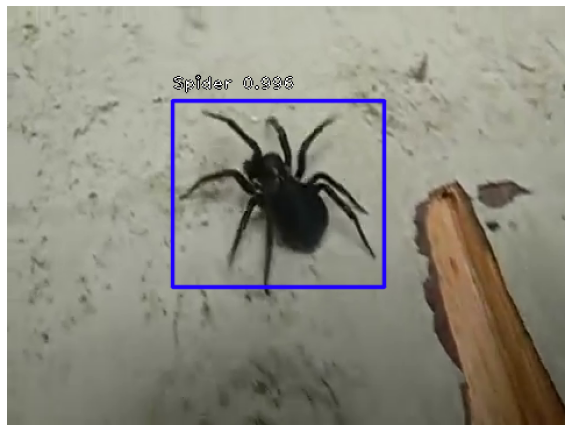

processing time:  0.2610313892364502


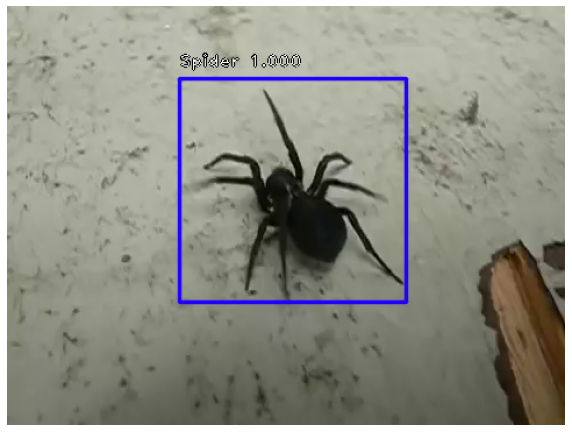

processing time:  0.2586350440979004


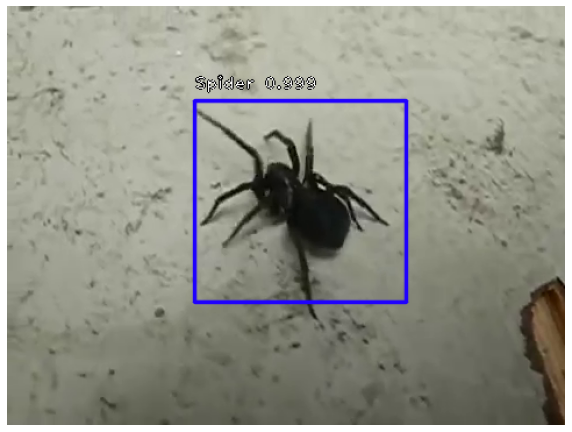

processing time:  0.25478172302246094


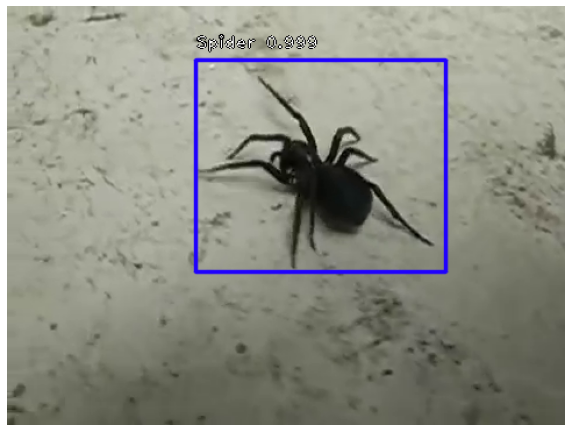

processing time:  0.2616288661956787


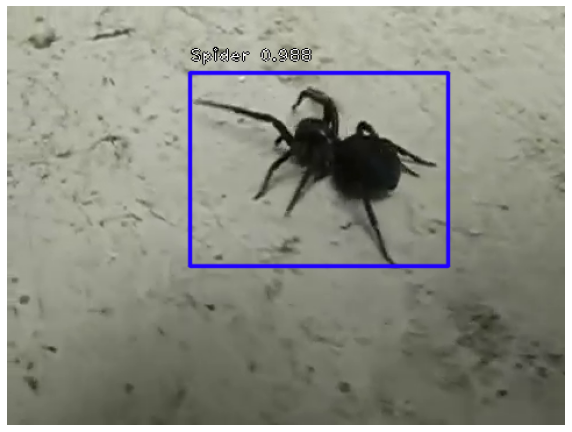

processing time:  0.2559356689453125


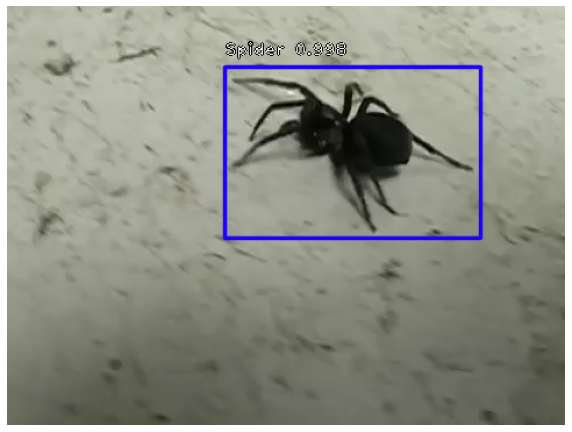

processing time:  0.258472204208374


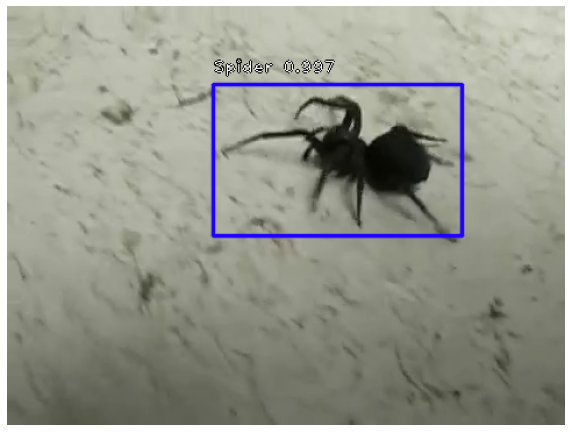

processing time:  0.2646498680114746


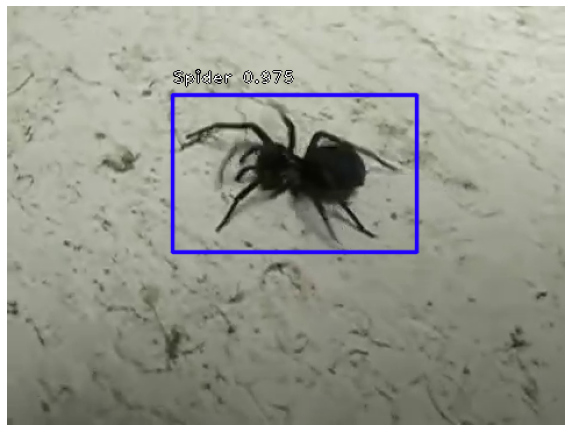

processing time:  0.26014018058776855
processing time:  0.26172494888305664


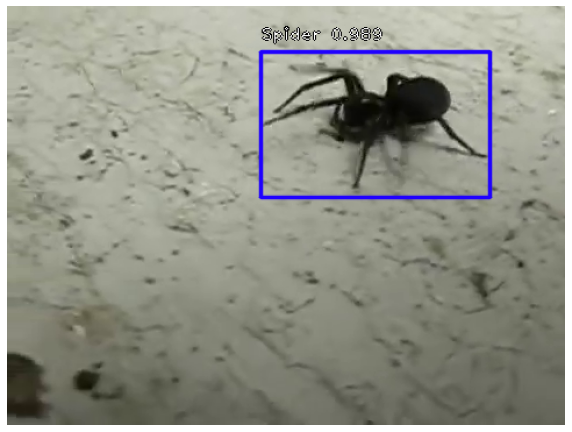

processing time:  0.263474702835083
processing time:  0.26029276847839355


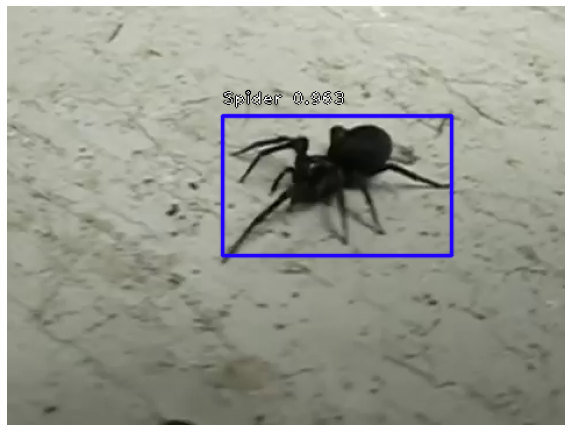

processing time:  0.26937389373779297


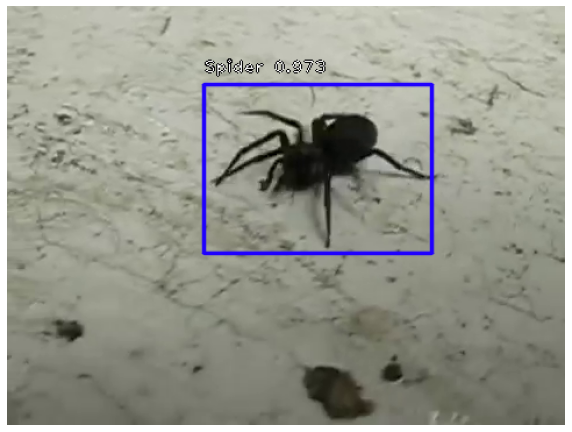

processing time:  0.25821471214294434


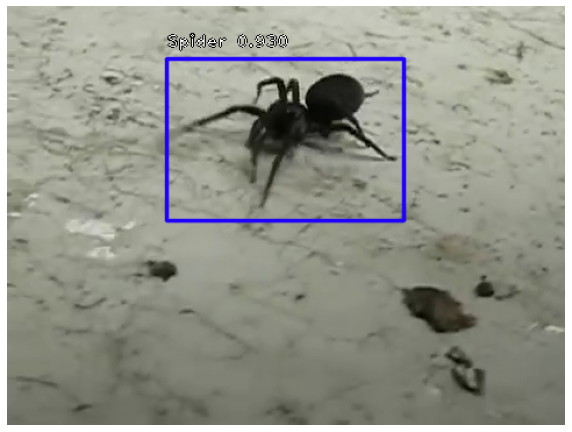

processing time:  0.26038050651550293
processing time:  0.26131391525268555
processing time:  0.26953744888305664
processing time:  0.2635016441345215


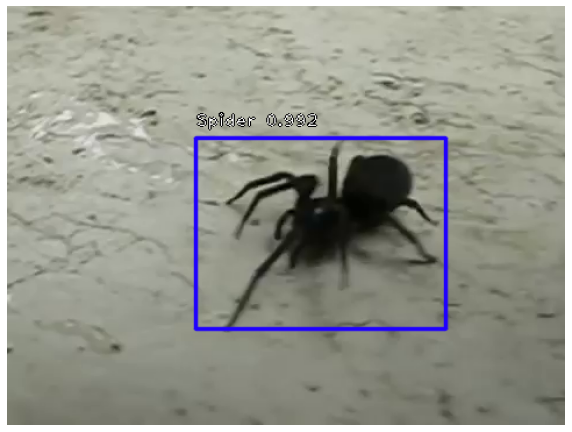

processing time:  0.26607251167297363


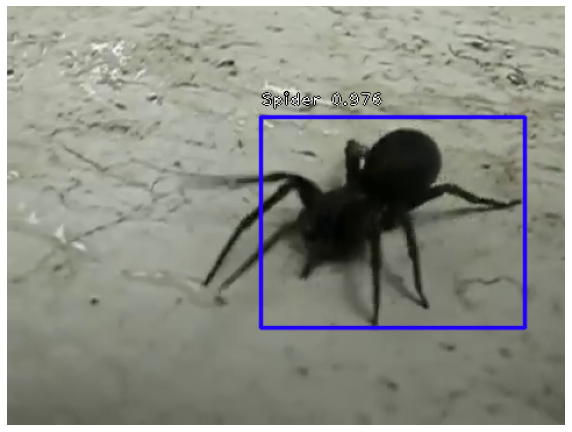

In [30]:
def img_inference1():
  cap = cv2.VideoCapture('/content/keras-retinanet/videoplayback.mp4')
  i = 0
  while(cap.isOpened()):
    ret, image = cap.read()
    if ret:
      # image = read_image_bgr(frame)
      if i % 10 == 0:
        draw = image.copy()
        draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
        image = preprocess_image(image)
        image, scale = resize_image(image)
        start = time.time()
        boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
        print("processing time: ", time.time() - start)
        boxes /= scale
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            if score < THRES_SCORE:
                break
            color = label_color(label)
            b = box.astype(int)
            draw_box(draw, b, color=color)
            caption = "{} {:.3f}".format(labels_to_names[label], score)
            draw_caption(draw, b, caption)
            plt.figure(figsize=(10, 10))
            plt.axis('off')
            plt.imshow(draw)
            plt.show()
      i = i + 1
      if cv2.waitKey(1)  & 0xFF == ord('q'):
            break
    else:
        break
  cap.release()
  cv2.destroyAllWindows()
img_inference1()
      